# Imports

In [1]:
import monkeybread as mb
import scanpy as sc

/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load processed adata

In [2]:
adata = sc.read_h5ad(r"/mnt/work/RO_src/data/processed/PipelineRun_2024_06_26-08_35_14_AM/ST/Files/deconvoluted_adata.h5ad")

# Co-localization

## Monkeybread

### Visualizing neighbor cells

- Here we compute a mapping of each cell of a given cell type to all neighboring cells within a specified radius. Here we identify all CD4 T cell neighbors of each dendritic cell (mregDC). Notice, each argument is a list denoting a union of cell types. Here we identify all neighbors of mature regulatory DCs (mregDCs), conventional DCs, and pDCs that are CD4 T cells.

In [4]:

# replace the strings "_Mean_LogNorm_Conn_Adj_scMAGS" to ""
adata.obs["cell_type"] = adata.obs["cell_type"].str.replace("_Mean_LogNorm_Conn_Adj_scMAGS", "")

In [7]:
adata.obsm["X_spatial"] = adata.obsm["spatial"]

In [14]:
cell_to_neighbors = mb.calc.cell_neighbors(
    adata,
    groupby='cell_type',
    group1=['AT1'],
    group2=['AT2'],
    radius=250
) 

/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


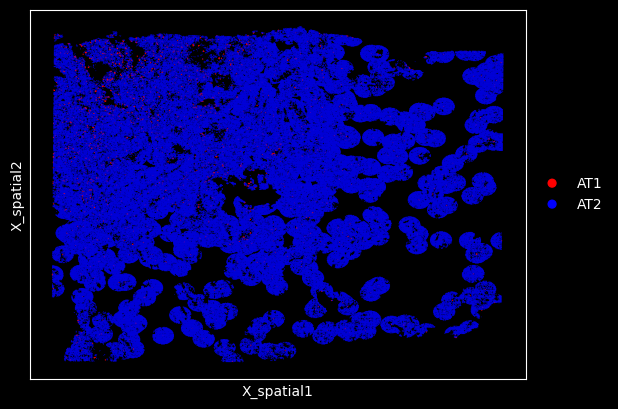

In [15]:
# Draw neighboring cells where we group the dendritic cells together
mb.plot.cell_neighbor_embedding(
    adata,
    cell_to_neighbors,
    palette=['Red', 'Blue'],
    group1_name='AT1',
    group2_name='AT2',
    dot_size_group1=1,
    dot_size_group2=1,
)

* Alternatively, we can color by each cell type that we are plotting instead of dividing the cells into the two groups

In [ ]:
# Draw neighboring cells, but color by each cell's type
mb.plot.cell_neighbor_embedding(
    adata,
    cell_to_neighbors,
    group='Cell Type',
    dot_size_group1=3,
    dot_size_group2=2,
)

### Restricting neighbors to a specific niche


- Monkeybread provides a function to find neighboring cells, but restricted to each niche. The following function will output a dictionary mapping each niche to a sub-dictionary mapping each dendritic cell to its neighboring T cells

In [32]:
niche_to_cell_to_neighbors = mb.calc.cell_neighbors_per_niche(
    adata,
    niche_key='leiden_clusters',
    groupby='cell_type',
    group1=["B cell lineage"],
    group2=["T cell lineage"],
    basis="X_spatial",
    radius=2500,
)

/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


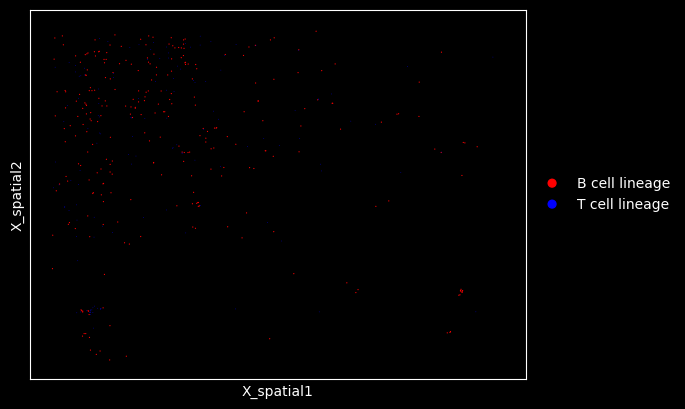

In [34]:
# Draw neighboring cells, but color by each cell's type
mb.plot.cell_neighbor_embedding(
    adata,
    niche_to_cell_to_neighbors['8'],
    palette=['Red', 'Blue'],
    group1_name="B cell lineage",
    group2_name="T cell lineage",
    dot_size_group1=3,
    dot_size_group2=1,
)

### Using Boolean-valued masks to define cell groups


- Instead of specifying cell types by using values in a specific column of adata.obs, we can also select the two groups using Boolean-valued masks. Below, we generate and plot all dendritic cell/T cell neighbors, but specify the dendritic cells and T cells using two masks. This function can be used to compute neighbors between groups of cells in a more customizable way.

In [ ]:
# Compute neighbors using masks
cell_to_neighbors = mb.calc.cell_neighbors_from_masks(
    adata,
    mask_group1=adata.obs['Cell Type'].isin(['mregDC', 'cDC', 'pDC']),   # Mask defining Group 1
    mask_group2=adata.obs['Cell Type'].isin(['CD4 T', 'CD8 T', 'Treg']), # Mask defining Group 2
    radius=20
) 

# Draw neighboring cells
mb.plot.cell_neighbor_embedding(
    adata,
    cell_to_neighbors,
    palette=['Red', 'Blue'],
    group1_name='Dendritic cell',
    group2_name='T cell',
    dot_size_group1=3,
    dot_size_group2=1,
)

### Statistical test of co-localization

In [37]:
adata.obs["cell_type"].unique()

['AT2', 'Fibroblasts', 'Mast cells', 'EC capillary', 'Unknown', ..., 'T cell lineage', 'AT1', 'Innate lymphoid cell NK', 'EC arterial', 'Lymphatic EC mature']
Length: 15
Categories (15, object): ['2_Smooth muscle', 'AT1', 'AT2', 'B cell lineage', ..., 'Macrophages', 'Mast cells', 'T cell lineage', 'Unknown']

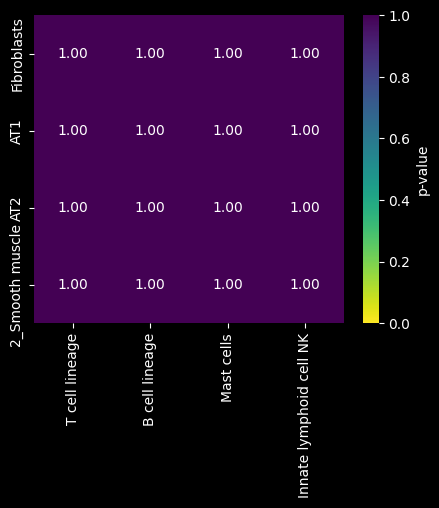

In [38]:
# Only look in niches that are not the malignant/other niche

# Define cell types we want to analyze
STROMA = [
"Fibroblasts","AT1","AT2","2_Smooth muscle"
]
IMMUNE = [
"T cell lineage", "B cell lineage","Mast cells","Innate lymphoid cell NK"
]

# Compute distance from each myeloid cell type to the nearest T cell subtype
ct1_to_ct2_to_dists = mb.calc.shortest_distances_pairwise(
    adata, 
    'cell_type', 
    STROMA, 
    IMMUNE
)

# Calculate significance of these shortest distances
ct1_to_ct2_to_perms, ct1_to_ct2_to_pval = mb.stat.shortest_distances_pairwise(
    adata, 
    'cell_type', 
    STROMA, 
    IMMUNE,
    n_perms=100,
    observed=ct1_to_ct2_to_dists, 
    threshold=20
)


fig, ax = mb.plot.shortest_distances_pairwise(
    ct1_to_ct2_to_pval,
    order_x=IMMUNE,
    order_y=STROMA,
    figsize=(5,4),
    show=False
);

In [41]:
lr_pairs = mb.util.load_ligand_receptor_pairs_omnipath(adata)


UnpicklingError: pickle data was truncated

In [ ]:
# For each pDC, find the neighboring Tregs
cell_to_neighbors = mb.calc.cell_neighbors(
    adata,
    groupby='Cell Type',
    group1=['mono/mac'],
    group2=['CD8 T', 'CD4 T', 'Treg'],
    radius=20
) 

lr_pair_to_score = mb.calc.ligand_receptor_score(
    adata,
    cell_to_neighbors,
    lr_pairs=lr_pairs
)
lr_pair_to_score

In [ ]:
res = mb.stat.ligand_receptor_score(
    adata,
    cell_to_neighbors,
    actual_scores=lr_pair_to_score
)

In [ ]:
mb.plot.ligand_receptor_scatter(
    lr_pair_to_score,
    res
)